In [286]:
import plotly.express as px 
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import prophet
df = pd.read_csv("datos_limpios_pro.csv")

In [287]:
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d')
# Crear la nueva columna 'date_block_num'
df['date_block_num'] = (df['fecha'].dt.year - 2021) * 12 + df['fecha'].dt.month - 2

In [288]:
df.columns

Index(['codigo', 'descrip', 'cod_sector', 'fecha', 'design', 'pantone',
       'nombre_color', 'cantidad', 'suc', 'temporada_venta', 'date_block_num'],
      dtype='object')

In [289]:
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')

# Agrupar y sumar la columna 'cantidad' para filas con la misma fecha, descrip, design, nombre_color y sucursal
df = df.groupby(['fecha', 'descrip', 'design', 'nombre_color', 'suc',"date_block_num","temporada_venta"]).agg({'cantidad': 'sum'}).reset_index()
df['fecha'] = df['fecha'].dt.strftime('%d/%m/%Y')

In [290]:
# Transformando a formato fecha
df["fecha"] = df.fecha.apply(lambda x:datetime.datetime.strptime(x, '%d/%m/%Y'))
# Creando variables de mes y dia para considerar en el modelo
df["mes"] = df["fecha"].dt.month
df["dia"] = df["fecha"].dt.day

In [291]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,fecha,suc,date_block_num,cantidad,mes,dia
count,1437191.00000,1437191.00000,1437191.00000,1437191.00000,1437191.00000,1437191.00000
mean,.5f,9.38830,15.51654,11.04967,6.49940,15.52192
min,.5f,0.00000,0.00000,0.03000,1.00000,1.00000
25%,.5f,2.00000,8.00000,1.00000,4.00000,8.00000
50%,.5f,5.00000,16.00000,2.00000,6.00000,16.00000
75%,.5f,10.00000,23.00000,3.70000,9.00000,23.00000
max,.5f,30.00000,30.00000,31020.30000,12.00000,31.00000
std,nan,9.85417,8.77264,105.14796,3.31510,8.72387


<Axes: >

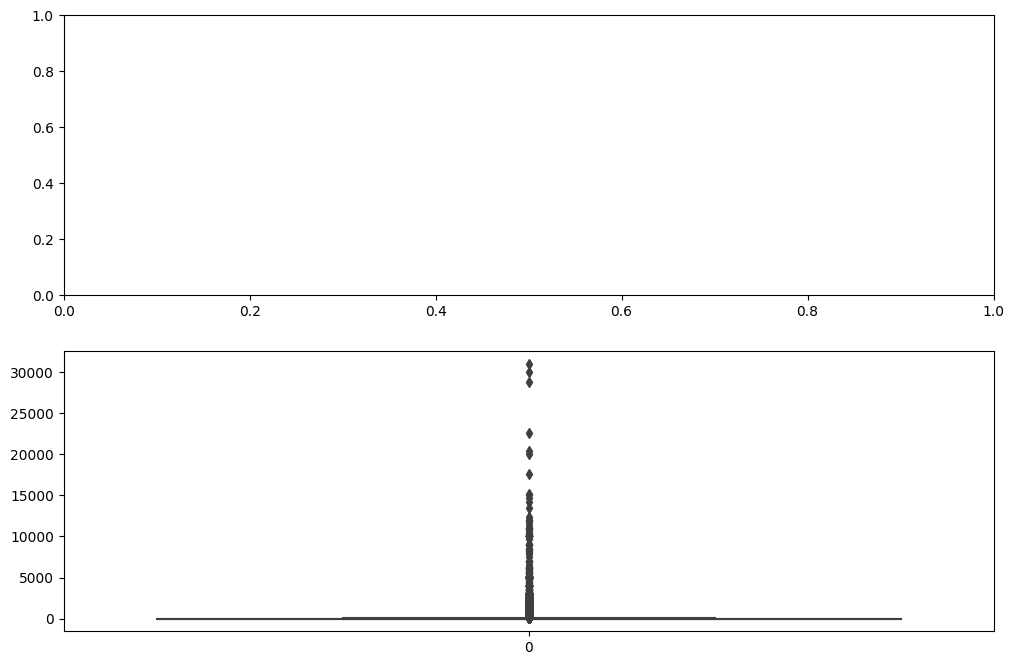

In [292]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(df["cantidad"], ax=ax[1])

In [293]:
df = df.loc[df["cantidad"] <= 10000]
print("Conjunto de datos de ventas corregidos")
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Conjunto de datos de ventas corregidos


,fecha,suc,date_block_num,cantidad,mes,dia
count,1437157.00000,1437157.00000,1437157.00000,1437157.00000,1437157.00000,1437157.00000
mean,.5f,9.38829,15.51643,10.71664,6.49942,15.52187
min,.5f,0.00000,0.00000,0.03000,1.00000,1.00000
25%,.5f,2.00000,8.00000,1.00000,4.00000,8.00000
50%,.5f,5.00000,16.00000,2.00000,6.00000,16.00000
75%,.5f,10.00000,23.00000,3.70000,9.00000,23.00000
max,.5f,30.00000,30.00000,10000.00000,12.00000,31.00000
std,nan,9.85408,8.77267,74.47352,3.31509,8.72384


<Axes: >

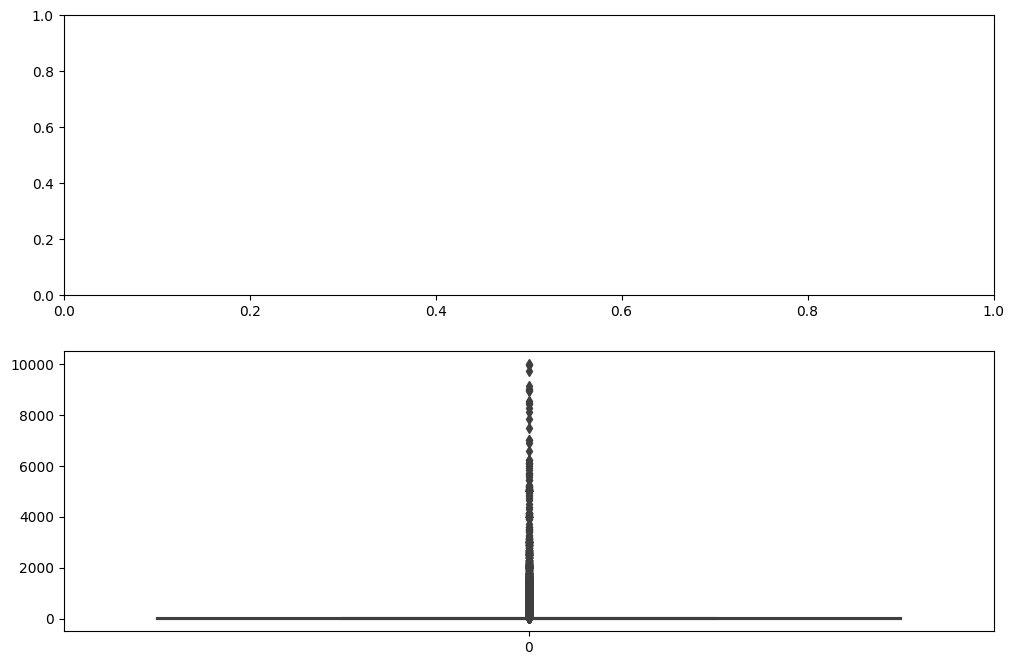

In [294]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(df["cantidad"], ax=ax[1])

¿Cúantos items fueron vendidos por mes?

<Axes: xlabel='fecha', ylabel='cantidad'>

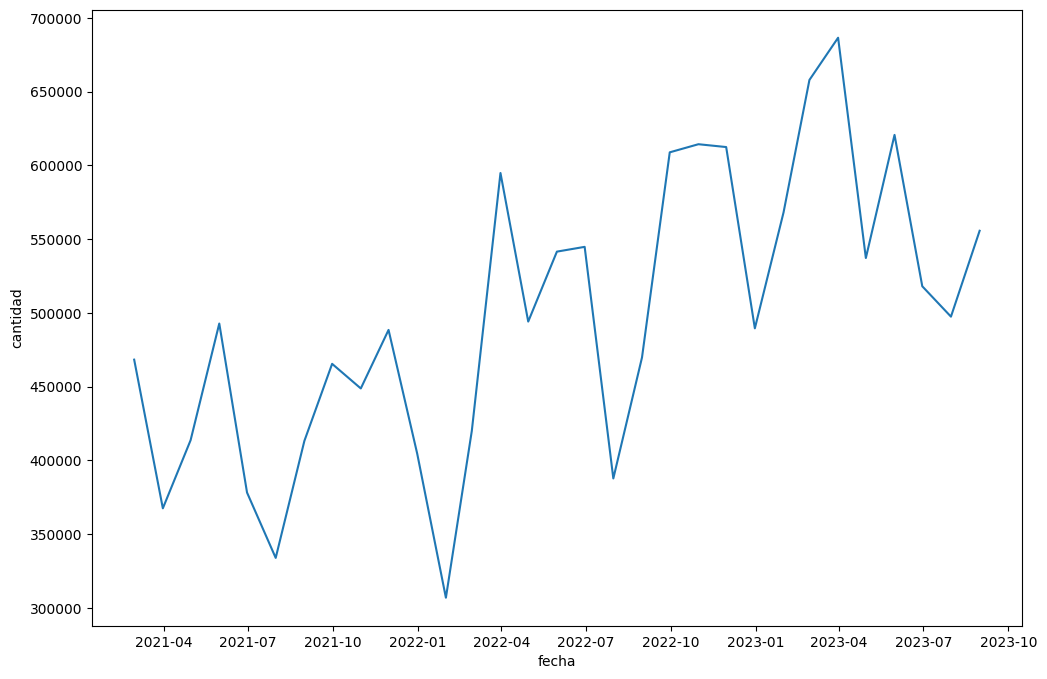

In [295]:
ventas_tiempo = df.copy()
ventas_tiempo = ventas_tiempo.set_index('fecha')
total_items_por_mes = ventas_tiempo.cantidad.resample('M').sum()

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=total_items_por_mes, ax=ax)

¿Cuál tienda tiene un mayor volumen de ventas?

<Axes: xlabel='suc', ylabel='cantidad'>

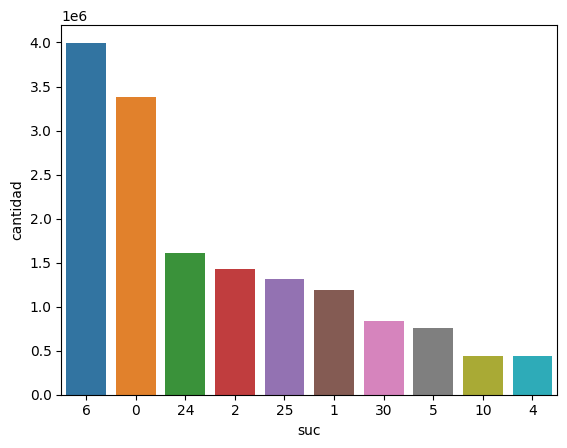

In [296]:
ventas_tienda = df.groupby(["suc"])["cantidad"].sum()
ventas_tienda.sort_values(ascending=False, inplace=True)
ventas_tienda = ventas_tienda[0:10].reset_index()
sns.barplot(y="cantidad", x="suc", data=ventas_tienda, order=ventas_tienda.sort_values('cantidad', ascending=False)["suc"])

¿Cuál es el item mas popular en cada tienda?

In [297]:
ventas_tienda_item = df.groupby(["suc","descrip"])["cantidad"].sum().reset_index()

for tienda in ventas_tienda_item.suc.unique():
    agg_ventas_tienda = ventas_tienda_item.loc[ventas_tienda_item["suc"] == tienda]
    item_tienda_sort = agg_ventas_tienda.sort_values(["cantidad"], ascending=False)
    print(item_tienda_sort.max())

suc                         0
descrip     VIYELAS ESTAMPADA
cantidad            525813.35
dtype: object
suc                    1
descrip     VOLADOS LOLA
cantidad       160545.18
dtype: object
suc                    2
descrip     VOLADOS LOLA
cantidad       251833.04
dtype: object
suc                    4
descrip     VOLADOS LOLA
cantidad        68384.51
dtype: object
suc                    5
descrip     VOLADOS LOLA
cantidad        124887.9
dtype: object
suc                     6
descrip      VOLADOS LOLA
cantidad    745872.984497
dtype: object
suc                   10
descrip     VOLADOS LOLA
cantidad        51859.67
dtype: object
suc                    24
descrip      VOLADOS LOLA
cantidad    272716.694184
dtype: object
suc                   25
descrip     VOLADOS LOLA
cantidad       159778.53
dtype: object
suc                        30
descrip     VIYELAS ESTAMPADA
cantidad             96024.74
dtype: object


01 - Encarnación 1
02 - Encarnación 2
04 - Hohenau
05 - Santa Rita
06 - CDE 3.5
10 - CDE Centro
24 - San Lorenzo
25 - Asunción
30 - Lambaré

Si tuvieramos por ejemplo el precio de cada venta, podriamos determinar que sucursales son las que tienen mayor ganancia y son mas rentables, porque no siempre las que mas venden son las que mas ganan.

El trend de tiempo muestra picos claramente definidos para los meses de abril y mayo, asi que resulta de interes saber que tiendas e items se venden durante estos meses en particular.

<Axes: xlabel='suc', ylabel='cantidad'>

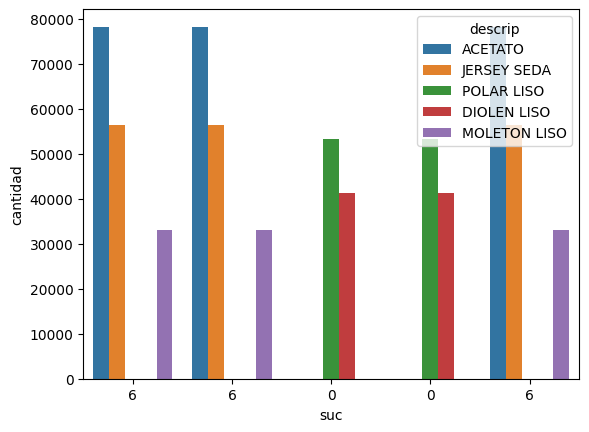

In [298]:
abril_ventas = df.loc[df["mes"] == 4]
group_abril_ventas = abril_ventas.groupby(["suc", "descrip"])["cantidad"].sum().reset_index()
top_5_abril = group_abril_ventas.sort_values(["cantidad"], ascending=False)[0:5]

sns.barplot(y="cantidad", x="suc", data=top_5_abril, 
            order=top_5_abril.sort_values('cantidad', ascending=False)["suc"],
            hue="descrip")

Ahora usaremos un producto en especifico para empezar a hacer predicciones.

In [328]:
def limpiar_color(color):
    partes = color.split()
    return partes[0]

# Aplicar la función a la columna "nombre_color" y crear una nueva columna llamada "color_limpiado"
df['nombre_color'] = df['nombre_color'].apply(limpiar_color)
df['nombre_color'].unique()

array(['VERDE', 'AZUL', 'BLANCO', 'GRIS', 'NEGRO', 'ROJO', 'ROSA',
       'BEIGE', 'VIOLETA', 'MARRON', 'CHOCOLATE', 'FUCSIA', 'TURQUESA',
       'CAMEL', 'VAINILLA', 'BORDO', 'CELESTE', 'LILA', 'NARANJA',
       'AMARILLO', 'AGUAMARINA', 'SALMON', 'CORAL', 'MAGENTA', 'NATURAL',
       'MARFIL', 'SIN', 'PURPURA', 'MOSTAZA', 'CIELO', 'OCRE',
       'MELOCOTON', 'MORADO', 'COBRE', 'LAVANDA'], dtype=object)

In [334]:
df = df.groupby(['fecha', 'descrip', 'nombre_color', 'suc']).agg({'cantidad': 'sum'}).reset_index()

# Eliminar columnas innecesarias
df = df[['fecha', 'descrip', 'nombre_color', 'suc', 'cantidad']]

In [443]:
poplin = df[(df['descrip'] == 'DIOLEN LISO') & 
              (df['nombre_color'] == 'BLANCO') & 
              (df['suc'].astype('int64') == 2)]

In [371]:
frecuencia_colores = poplin["nombre_color"].value_counts()

# Obtener el color con la mayor frecuencia
color_mas_frecuente = frecuencia_colores.idxmax()

# Obtener la cantidad de registros para el color más frecuente
cantidad_registros_color_mas_frecuente = frecuencia_colores.max()

# Imprimir los resultados
print(f"Color más frecuente: {color_mas_frecuente}")
print(f"Cantidad de registros para el color más frecuente: {cantidad_registros_color_mas_frecuente}")

Color más frecuente: BLANCO
Cantidad de registros para el color más frecuente: 774


In [444]:
poplin = poplin[["fecha", "cantidad"]]
poplin.columns = ["ds","y"]
poplin["ds"].unique().shape

(774,)

In [355]:
from prophet import Prophet
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid
import numpy as np


In [373]:
def cross_validate_prophet(params, df, horizon='30 days', period='15 days', initial='774 days'):
    model = Prophet(**params)
    
    # Ajustar el modelo antes de la validación cruzada
    model.fit(df)
    
    df_cv = cross_validation(model, initial=str(len(poplin)) + ' days', period=period, horizon=horizon)
    df_p = performance_metrics(df_cv)
    return df_p['rmse'].values[0]


# Definir los parámetros que quieres probar
grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
}

# Mejores parámetros iniciales
best_params = None
best_rmse = float('inf')

# Realizar la búsqueda de cuadrícula
for seasonality_mode in grid['seasonality_mode']:
    for changepoint_prior_scale in grid['changepoint_prior_scale']:
        params = {
            'seasonality_mode': seasonality_mode,
            'changepoint_prior_scale': changepoint_prior_scale,
        }
        
        rmse = cross_validate_prophet(params, poplin)
        print(f"Params: {params}, RMSE: {rmse}")
        
        # Actualizar los mejores parámetros si se encuentra un modelo con menor RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

print(f"Mejores parámetros encontrados: {best_params}, Mejor RMSE: {best_rmse}")

00:07:12 - cmdstanpy - INFO - Chain [1] start processing
00:07:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

00:07:14 - cmdstanpy - INFO - Chain [1] start processing
00:07:14 - cmdstanpy - INFO - Chain [1] done processing
00:07:15 - cmdstanpy - INFO - Chain [1] start processing
00:07:15 - cmdstanpy - INFO - Chain [1] done processing
00:07:16 - cmdstanpy - INFO - Chain [1] start processing
00:07:16 - cmdstanpy - INFO - Chain [1] done processing
00:07:17 - cmdstanpy - INFO - Chain [1] start processing
00:07:18 - cmdstanpy - INFO - Chain [1] done processing
00:07:18 - cmdstanpy - INFO - Chain [1] start processing
00:07:19 - cmdstanpy - INFO - Chain [1] done processing
00:07:20 - cmdstanpy - INFO - Chain [1] start processing
00:07:20 - cmdstanpy - INFO - Chain [1] done processing
00:07:20 - cmdstanpy - INFO - Chain [1] start processing
00:07:21 - cmdstanpy - INFO - Chain [1] done processing
00:07:21 - cmdstanpy - INFO - Chain [1] start processing
00:07:22 - cmdstanpy - INFO - Chain [1] done processing
00:07:23 - cmdstanpy - INFO - Chain [1] start processing
00:07:23 - cmdstanpy - INFO - Chain [1]

Params: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01}, RMSE: 151.4444986054824


00:07:24 - cmdstanpy - INFO - Chain [1] start processing
00:07:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

00:07:25 - cmdstanpy - INFO - Chain [1] start processing
00:07:25 - cmdstanpy - INFO - Chain [1] done processing
00:07:26 - cmdstanpy - INFO - Chain [1] start processing
00:07:27 - cmdstanpy - INFO - Chain [1] done processing
00:07:27 - cmdstanpy - INFO - Chain [1] start processing
00:07:28 - cmdstanpy - INFO - Chain [1] done processing
00:07:28 - cmdstanpy - INFO - Chain [1] start processing
00:07:29 - cmdstanpy - INFO - Chain [1] done processing
00:07:30 - cmdstanpy - INFO - Chain [1] start processing
00:07:30 - cmdstanpy - INFO - Chain [1] done processing
00:07:31 - cmdstanpy - INFO - Chain [1] start processing
00:07:32 - cmdstanpy - INFO - Chain [1] done processing
00:07:33 - cmdstanpy - INFO - Chain [1] start processing
00:07:33 - cmdstanpy - INFO - Chain [1] done processing
00:07:34 - cmdstanpy - INFO - Chain [1] start processing
00:07:34 - cmdstanpy - INFO - Chain [1] done processing
00:07:35 - cmdstanpy - INFO - Chain [1] start processing
00:07:36 - cmdstanpy - INFO - Chain [1]

Params: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1}, RMSE: 155.95131505773247


00:07:37 - cmdstanpy - INFO - Chain [1] start processing
00:07:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

00:07:39 - cmdstanpy - INFO - Chain [1] start processing
00:07:40 - cmdstanpy - INFO - Chain [1] done processing
00:07:41 - cmdstanpy - INFO - Chain [1] start processing
00:07:42 - cmdstanpy - INFO - Chain [1] done processing
00:07:42 - cmdstanpy - INFO - Chain [1] start processing
00:07:43 - cmdstanpy - INFO - Chain [1] done processing
00:07:44 - cmdstanpy - INFO - Chain [1] start processing
00:07:44 - cmdstanpy - INFO - Chain [1] done processing
00:07:45 - cmdstanpy - INFO - Chain [1] start processing
00:07:45 - cmdstanpy - INFO - Chain [1] done processing
00:07:46 - cmdstanpy - INFO - Chain [1] start processing
00:07:46 - cmdstanpy - INFO - Chain [1] done processing
00:07:47 - cmdstanpy - INFO - Chain [1] start processing
00:07:47 - cmdstanpy - INFO - Chain [1] done processing
00:07:48 - cmdstanpy - INFO - Chain [1] start processing
00:07:48 - cmdstanpy - INFO - Chain [1] done processing
00:07:49 - cmdstanpy - INFO - Chain [1] start processing
00:07:49 - cmdstanpy - INFO - Chain [1]

Params: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5}, RMSE: 159.8979982009017


00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

00:07:52 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing
00:07:53 - cmdstanpy - INFO - Chain [1] start processing
00:07:53 - cmdstanpy - INFO - Chain [1] done processing
00:07:54 - cmdstanpy - INFO - Chain [1] start processing
00:07:54 - cmdstanpy - INFO - Chain [1] done processing
00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:55 - cmdstanpy - INFO - Chain [1] done processing
00:07:55 - cmdstanpy - INFO - Chain [1] start processing
00:07:56 - cmdstanpy - INFO - Chain [1] done processing
00:07:56 - cmdstanpy - INFO - Chain [1] start processing
00:07:57 - cmdstanpy - INFO - Chain [1] done processing
00:07:57 - cmdstanpy - INFO - Chain [1] start processing
00:07:58 - cmdstanpy - INFO - Chain [1] done processing
00:07:58 - cmdstanpy - INFO - Chain [1] start processing
00:07:59 - cmdstanpy - INFO - Chain [1] done processing
00:07:59 - cmdstanpy - INFO - Chain [1] start processing
00:07:59 - cmdstanpy - INFO - Chain [1]

Params: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01}, RMSE: 155.46080231333028


00:08:00 - cmdstanpy - INFO - Chain [1] start processing
00:08:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

00:08:01 - cmdstanpy - INFO - Chain [1] start processing
00:08:01 - cmdstanpy - INFO - Chain [1] done processing
00:08:02 - cmdstanpy - INFO - Chain [1] start processing
00:08:02 - cmdstanpy - INFO - Chain [1] done processing
00:08:03 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing
00:08:04 - cmdstanpy - INFO - Chain [1] start processing
00:08:04 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:05 - cmdstanpy - INFO - Chain [1] done processing
00:08:05 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing
00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:07 - cmdstanpy - INFO - Chain [1] done processing
00:08:07 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing
00:08:08 - cmdstanpy - INFO - Chain [1] start processing
00:08:09 - cmdstanpy - INFO - Chain [1]

Params: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1}, RMSE: 162.23355598802232


00:08:10 - cmdstanpy - INFO - Chain [1] start processing
00:08:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/9 [00:00<?, ?it/s]

00:08:11 - cmdstanpy - INFO - Chain [1] start processing
00:08:11 - cmdstanpy - INFO - Chain [1] done processing
00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:13 - cmdstanpy - INFO - Chain [1] done processing
00:08:13 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing
00:08:14 - cmdstanpy - INFO - Chain [1] start processing
00:08:15 - cmdstanpy - INFO - Chain [1] done processing
00:08:15 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing
00:08:16 - cmdstanpy - INFO - Chain [1] start processing
00:08:16 - cmdstanpy - INFO - Chain [1] done processing
00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:17 - cmdstanpy - INFO - Chain [1] done processing
00:08:18 - cmdstanpy - INFO - Chain [1] start processing
00:08:18 - cmdstanpy - INFO - Chain [1] done processing
00:08:19 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1]

Params: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5}, RMSE: 165.71139783208721
Mejores parámetros encontrados: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01}, Mejor RMSE: 151.4444986054824


In [381]:
frame = poplin

In [445]:
poplin

,ds,y
307,2021-02-01,29.00
1920,2021-02-02,4.00
3447,2021-02-03,9.00
5013,2021-02-04,80.00
6640,2021-02-05,216.50
...,...,...
1274899,2023-08-18,293.00
1276574,2023-08-19,32.00
1278051,2023-08-21,30.65
1280231,2023-08-22,19.25


In [449]:
m = Prophet(interval_width=0.95)

In [450]:
traning_run = m.fit(frame)

07:29:10 - cmdstanpy - INFO - Chain [1] start processing
07:29:13 - cmdstanpy - INFO - Chain [1] done processing


In [383]:
# Evaluaremos nuestros resultados

In [451]:
future = m.make_future_dataframe(periods=372,freq="D")

In [452]:
forcast = m.predict(future)

In [453]:
forcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-01,50.123202,-124.880266,147.570424,50.123202,50.123202,-37.666504,-37.666504,-37.666504,-3.193371,-3.193371,-3.193371,-34.473133,-34.473133,-34.473133,0.0,0.0,0.0,12.456698
1,2021-02-02,50.148283,-115.457363,170.785852,50.148283,50.148283,-24.026626,-24.026626,-24.026626,10.133561,10.133561,10.133561,-34.160187,-34.160187,-34.160187,0.0,0.0,0.0,26.121657
2,2021-02-03,50.173364,-106.060909,184.930484,50.173364,50.173364,-9.563386,-9.563386,-9.563386,24.087491,24.087491,24.087491,-33.650876,-33.650876,-33.650876,0.0,0.0,0.0,40.609978
3,2021-02-04,50.198445,-108.159953,163.559273,50.198445,50.198445,-21.202387,-21.202387,-21.202387,11.748628,11.748628,11.748628,-32.951015,-32.951015,-32.951015,0.0,0.0,0.0,28.996058
4,2021-02-05,50.223526,-110.318174,173.575919,50.223526,50.223526,-20.236170,-20.236170,-20.236170,11.835542,11.835542,11.835542,-32.071712,-32.071712,-32.071712,0.0,0.0,0.0,29.987356


In [454]:
forcast["yhat"].min()

-39.40218219186552

In [446]:
#filtramos
poplin = poplin[poplin['ds'] >= '2022-08-23']


# Crear el gráfico con Plotly Express
fig = px.line(poplin, x='ds', y='y', title='Gráfico de Ventas Diarias')

# Mostrar el gráfico
fig.show()

In [455]:
forcast_filtered = forcast[forcast['ds'] >= '2023-08-23']

# Crear el gráfico con Plotly Express
fig = px.line(forcast_filtered, x='ds', y='yhat', title='Gráfico de Ventas Diarias desde 23/08/2023 al 29 de agosto del 2024')

# Mostrar el gráfico
fig.show()

In [448]:
df["descrip"].unique().shape

(849,)

In [456]:
def limpiar_tela(descrip):
    partes = descrip.split()
    return partes[0]

# Aplicar la función a la columna "nombre_color" y crear una nueva columna llamada "color_limpiado"
df['descrip'] = df['descrip'].apply(limpiar_tela)
df['descrip'].unique()

array(['ACCESORIO', 'ACETATO', 'ALEMANISCO', 'ALFOMBRA', 'ANTISOLAR',
       'ARPILLERA', 'BATISTA', 'BENGALINA', 'BLACKOUT', 'BOAL', 'BOUCLE',
       'BROCATO', 'BRODERIE', 'BUZO', 'CANVAS', 'CASHMERE', 'CHAROLINA',
       'CHENILLE', 'CONVEX', 'CORDERINA', 'CORDERITO', 'CORTINA', 'CREPE',
       'CUERINA', 'DENIM', 'DIOLEN', 'DRIL', 'DRY', 'ENCAJE', 'ENTRETELA',
       'FELPUDO', 'FIBRANA', 'FRANELA', 'GABARDINA', 'GASA', 'GEORGETTE',
       'GOBELINO', 'GOMA', 'GROSS', 'GUATA', 'GUIPIURE', 'HILOS',
       'IMPERMEABLE', 'INTERLOCK', 'JACQUARD', 'JERSEY', 'LAME',
       'LIENCILLO', 'LIENZO', 'LINO', 'LONETA', 'LYCRA', 'MALLA',
       'MANTEL', 'MANTELERIA', 'MICRO', 'MICROFIBRA', 'MICROTUL', 'MODAL',
       'MOLETON', 'MUSELINA', 'ORGANZA', 'PAILLETTE', 'PANA', 'PANAMA',
       'PANHOLENCI', 'PATA', 'PERCAL', 'PIEL', 'PIQUE', 'PISO', 'POLAR',
       'POPLIN', 'PRINCIPE', 'PUNTO', 'PVC', 'REDECILLA', 'RIBB',
       'RIPSTOP', 'SATEN', 'SCUBA', 'SEDA', 'SUECIA', 'SUPLEX', 'TACTEL',
  

In [457]:
frecuencia_combinaciones = df.groupby(['nombre_color', 'descrip', 'suc']).size().reset_index(name='cantidad_registros')

# Encontrar la combinación con la mayor cantidad de registros
combinacion_max_registros = frecuencia_combinaciones.loc[frecuencia_combinaciones['cantidad_registros'].idxmax()]

# Imprimir los resultados
print("Combinación con mayor cantidad de registros:")
print(combinacion_max_registros[['nombre_color', 'descrip', 'suc']])
print(f"Cantidad de registros: {combinacion_max_registros['cantidad_registros']}")

Combinación con mayor cantidad de registros:
nombre_color    BLANCO
descrip            TUL
suc                  2
Name: 3805, dtype: object
Cantidad de registros: 2693


In [460]:
tul = df[(df['descrip'] == 'TUL') & 
              (df['nombre_color'] == 'BLANCO') & 
              (df['suc'].astype('int64') == 2)]
tul = tul[["fecha", "cantidad"]]
tul.columns = ["ds","y"]
tul["ds"].unique().shape

(728,)

In [468]:
tul = frame

In [465]:
tul = tul.groupby(['ds']).agg({'y': 'sum'}).reset_index()


In [477]:
m = Prophet(interval_width=0.95)

In [478]:
traning_run = m.fit(frame)

07:41:55 - cmdstanpy - INFO - Chain [1] start processing
07:41:56 - cmdstanpy - INFO - Chain [1] done processing


In [484]:
future = m.make_future_dataframe(periods=366,freq="D")
future

,ds
0,2021-02-01
1,2021-02-02
2,2021-02-03
3,2021-02-04
4,2021-02-05
...,...
1135,2024-08-19
1136,2024-08-20
1137,2024-08-21
1138,2024-08-22


In [485]:
forcast = m.predict(future)

In [486]:
forcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-01,50.123202,-164.916167,199.185473,50.123202,50.123202,-37.666504,-37.666504,-37.666504,-3.193371,-3.193371,-3.193371,-34.473133,-34.473133,-34.473133,0.0,0.0,0.0,12.456698
1,2021-02-02,50.148283,-179.793612,239.761798,50.148283,50.148283,-24.026626,-24.026626,-24.026626,10.133561,10.133561,10.133561,-34.160187,-34.160187,-34.160187,0.0,0.0,0.0,26.121657
2,2021-02-03,50.173364,-157.334874,223.695832,50.173364,50.173364,-9.563386,-9.563386,-9.563386,24.087491,24.087491,24.087491,-33.650876,-33.650876,-33.650876,0.0,0.0,0.0,40.609978
3,2021-02-04,50.198445,-165.838760,219.851870,50.198445,50.198445,-21.202387,-21.202387,-21.202387,11.748628,11.748628,11.748628,-32.951015,-32.951015,-32.951015,0.0,0.0,0.0,28.996058
4,2021-02-05,50.223526,-151.949932,210.356374,50.223526,50.223526,-20.236170,-20.236170,-20.236170,11.835542,11.835542,11.835542,-32.071712,-32.071712,-32.071712,0.0,0.0,0.0,29.987356


In [487]:
forcast_filtered = forcast[forcast['ds'] >= '2023-08-23']

# Crear el gráfico con Plotly Express
fig = px.line(forcast_filtered, x='ds', y='yhat', title='Gráfico de Ventas Diarias desde 23/08/2023 al 29 de agosto del 2024')

# Mostrar el gráfico
fig.show()

In [533]:
datos2023 = pd.read_csv("datos_limpios_pro_CON2023.csv") 

In [534]:
columnas_deseadas = ['fecha', 'descrip',"suc","nombre_color","cantidad"]

In [535]:
datos2023 = datos2023[columnas_deseadas]

In [537]:
datos2023['nombre_color'] = datos2023['nombre_color'].apply(limpiar_color)
datos2023["descrip"] = datos2023["descrip"].apply(limpiar_tela)
datos2023['nombre_color'].unique().shape

(35,)

In [538]:
datos2023 = datos2023.groupby(['fecha', 'descrip', 'nombre_color', 'suc']).agg({'cantidad': 'sum'}).reset_index()

# Eliminar columnas innecesarias
datos2023 = datos2023[['fecha', 'descrip', 'nombre_color', 'suc', 'cantidad']]

In [539]:
frecuencia_combinaciones = datos2023.groupby(['nombre_color', 'descrip', 'suc']).size().reset_index(name='cantidad_registros')

# Encontrar la combinación con la mayor cantidad de registros
combinacion_max_registros = frecuencia_combinaciones.loc[frecuencia_combinaciones['cantidad_registros'].idxmax()]

# Imprimir los resultados
print("Combinación con mayor cantidad de registros:")
print(combinacion_max_registros[['nombre_color', 'descrip', 'suc']])
print(f"Cantidad de registros: {combinacion_max_registros['cantidad_registros']}")

Combinación con mayor cantidad de registros:
nombre_color    BLANCO
descrip         DIOLEN
suc                  2
Name: 3225, dtype: object
Cantidad de registros: 934


In [540]:
df = datos2023[(datos2023['descrip'] == 'DIOLEN') & 
              (datos2023['nombre_color'] == 'BLANCO') & 
              (datos2023['suc'].astype('int64') == 2)]

In [546]:
filtro_fechas = (df['fecha'] >= '2023-08-23') & (df['fecha'] <= '2023-12-31')
datos_filtrados = df[filtro_fechas]

# Calcula la sumatoria de la columna 'cantidad' en el DataFrame filtrado
sumatoria_cantidad = datos_filtrados['cantidad'].sum()

# Imprime la sumatoria
print(f"La sumatoria de 'cantidad' desde el 23/08/2023 hasta el 31/12/2023 es: {sumatoria_cantidad}")

La sumatoria de 'cantidad' desde el 23/08/2023 hasta el 31/12/2023 es: 14813.94


In [545]:
filtro_fechas = (forcast['ds'] >= '2023-08-23') & (forcast['ds'] <= '2023-12-31')
datos_filtrados = forcast[filtro_fechas]

# Calcula la sumatoria de la columna 'cantidad' en el DataFrame filtrado
sumatoria_cantidad = datos_filtrados['yhat'].sum()

# Imprime la sumatoria
print(f"La sumatoria de 'cantidad' desde el 23/08/2023 hasta el 31/12/2023 es: {sumatoria_cantidad}")

La sumatoria de 'cantidad' desde el 23/08/2023 hasta el 31/12/2023 es: 20918.497959270535
